In [107]:
import pandas as pd
import quandl,math, datetime
import numpy as np
from sklearn import preprocessing,svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [108]:
df = pd.read_excel("/Users/goktugkara/Desktop/Datalar/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [109]:
furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [110]:
furniture = furniture.groupby('Order Date')['Sales','Quantity','Discount','Profit'].sum().reset_index()

In [111]:
furniture.tail()

Order Date      Sales  Quantity  Discount    Profit
884 2017-12-24  1393.4940        14      0.50  222.9092
885 2017-12-25   832.4540        14      0.80   -7.0763
886 2017-12-28   551.2568        17      2.02  -49.6680
887 2017-12-29  2330.7180        26      0.20  492.6236
888 2017-12-30   323.1360         4      0.20   12.1176

In [112]:
df2 = pd.read_csv('/Users/goktugkara/Desktop/Datalar/ekonomi.csv')
df2 = df2.rename({'GDP ($ Billions)': 'gdp', 
                     'Federal Interest rate': 'faizorani',
                    'Electricity Charges (US Average)': 'elektrikucretleri',
                    'Employment to Population Ratio (US: Age Group 25-54)': 'istihdam',
                    'Unemployment Rate': 'issizlikorani',
                    'Population Growth': 'nufusartisi',
                    'Temperature (US Average)': 'sicaklik',
                    'Precipitation': 'yagis',
                    'Transportation Services Index': 'ulasimendeksi',
                    'Consumer Price Index': 'tuketiciendeksi',
                    'Consumer Price Index (Housing)': 'tuketicikonutendeksi',
                    'S&P House price index': 'konutfiyatendeksi'}, axis='columns')

In [113]:
df2.head(71)

Date        gdp  faizorani  elektrikucretleri  istihdam  \
0   Jan - 2010  14611.110       0.11              10.89      75.1   
1   Feb - 2010  14653.075       0.13              11.11      75.1   
2   Mar - 2010  14779.004       0.16              11.71      75.1   
3   Apr - 2010  14842.404       0.20              11.91      75.4   
4   May - 2010  14875.794       0.20              11.91      75.1   
..         ...        ...        ...                ...       ...   
66  Jul - 2015  18049.683       0.13              12.93      77.1   
67  Aug - 2015  18111.953       0.14              13.06      77.2   
68  Sep - 2015  18264.133       0.14              12.73      77.3   
69  Oct - 2015  18182.577       0.12              12.73      77.2   
70  Nov - 2015  18227.601       0.12              12.36      77.4   

    issizlikorani  nufusartisi  sicaklik  yagis  ulasimendeksi  \
0             9.8         0.78     30.67   2.62          103.3   
1             9.8         0.79     31.80   2.01          105.1   
2             9.9         0.79     43.57   2.30          105.5   
3             9.9         0.79     53.24   2.38          106.4   
4             9.6         0.80     59.88   3.32          106.2   
..            ...          ...       ...    ...            ...   
66            5.3         0.45     73.92   3.23          122.7   
67            5.1         0.46     72.95   2.41          122.8   
68            5.1         0.46     68.54   2.12          122.2   
69            5.0         0.86     57.25   2.90          122.8   
70            5.0         0.87     44.60   3.35          121.0   

    tuketiciendeksi  tuketicikonutendeksi  konutfiyatendeksi  
0           216.687               216.206             145.00  
1           216.741               216.042             143.06  
2           217.631               216.146             143.60  
3           218.009               216.092             145.39  
4           218.178               216.128             147.02  
..              ...                   ...                ...  
66          238.654               238.182             174.66  
67          238.316               238.631             175.12  
68          237.945               239.208             175.24  
69          237.838               239.675             175.26  
70          237.336               240.083             175.38  

[71 rows x 13 columns]

In [114]:
df2.columns

Index(['Date', 'gdp', 'faizorani', 'elektrikucretleri', 'istihdam',
       'issizlikorani', 'nufusartisi', 'sicaklik', 'yagis', 'ulasimendeksi',
       'tuketiciendeksi', 'tuketicikonutendeksi', 'konutfiyatendeksi'],
      dtype='object')

In [115]:
df2.drop(['Date', 'gdp', 'elektrikucretleri', 'istihdam',
       'issizlikorani', 'ulasimendeksi', 'tuketicikonutendeksi', 'konutfiyatendeksi'], axis=1, inplace=True)

In [116]:
df2.head()

faizorani  nufusartisi  sicaklik  yagis  tuketiciendeksi
0       0.11         0.78     30.67   2.62          216.687
1       0.13         0.79     31.80   2.01          216.741
2       0.16         0.79     43.57   2.30          217.631
3       0.20         0.79     53.24   2.38          218.009
4       0.20         0.80     59.88   3.32          218.178

In [117]:
from functools import reduce
dfs = [furniture, df2]
result = pd.concat(dfs, join='outer', axis=1)

In [118]:
result.head()

Order Date     Sales  Quantity  Discount    Profit  faizorani  nufusartisi  \
0 2014-01-06  2573.820         9      0.00  746.4078       0.11         0.78   
1 2014-01-07    76.728         3      0.60  -53.7096       0.13         0.79   
2 2014-01-10    51.940         1      0.00   21.2954       0.16         0.79   
3 2014-01-11     9.940         2      0.00    3.0814       0.20         0.79   
4 2014-01-13   879.939         9      0.15   91.2798       0.20         0.80   

   sicaklik  yagis  tuketiciendeksi  
0     30.67   2.62          216.687  
1     31.80   2.01          216.741  
2     43.57   2.30          217.631  
3     53.24   2.38          218.009  
4     59.88   3.32          218.178

In [119]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(result.iloc[:, 5:10])
result.iloc[:, 5:10] = imputer.transform(result.iloc[:, 5:10])

In [120]:
result.head()

Order Date     Sales  Quantity  Discount    Profit  faizorani  nufusartisi  \
0 2014-01-06  2573.820         9      0.00  746.4078       0.11         0.78   
1 2014-01-07    76.728         3      0.60  -53.7096       0.13         0.79   
2 2014-01-10    51.940         1      0.00   21.2954       0.16         0.79   
3 2014-01-11     9.940         2      0.00    3.0814       0.20         0.79   
4 2014-01-13   879.939         9      0.15   91.2798       0.20         0.80   

   sicaklik  yagis  tuketiciendeksi  
0     30.67   2.62          216.687  
1     31.80   2.01          216.741  
2     43.57   2.30          217.631  
3     53.24   2.38          218.009  
4     59.88   3.32          218.178

In [121]:
result.to_csv('final_sales.csv', index=False)

In [122]:
final_df = pd.read_csv('/Users/goktugkara/Desktop/final_sales.csv', parse_dates = True, low_memory = False, index_col = 'Order Date')

In [123]:
final_df.head()

Sales  Quantity  Discount    Profit  faizorani  nufusartisi  \
Order Date                                                                   
2014-01-06  2573.820         9      0.00  746.4078       0.11         0.78   
2014-01-07    76.728         3      0.60  -53.7096       0.13         0.79   
2014-01-10    51.940         1      0.00   21.2954       0.16         0.79   
2014-01-11     9.940         2      0.00    3.0814       0.20         0.79   
2014-01-13   879.939         9      0.15   91.2798       0.20         0.80   

            sicaklik  yagis  tuketiciendeksi  
Order Date                                    
2014-01-06     30.67   2.62          216.687  
2014-01-07     31.80   2.01          216.741  
2014-01-10     43.57   2.30          217.631  
2014-01-11     53.24   2.38          218.009  
2014-01-13     59.88   3.32          218.178

In [124]:
forecast_col = 'Sales'
forecast_out = int(math.ceil(0.09*len(final_df)))
print(forecast_out)

81


In [125]:
final_df['label'] = final_df[forecast_col].shift(-forecast_out)
final_df.head()

Sales  Quantity  Discount    Profit  faizorani  nufusartisi  \
Order Date                                                                   
2014-01-06  2573.820         9      0.00  746.4078       0.11         0.78   
2014-01-07    76.728         3      0.60  -53.7096       0.13         0.79   
2014-01-10    51.940         1      0.00   21.2954       0.16         0.79   
2014-01-11     9.940         2      0.00    3.0814       0.20         0.79   
2014-01-13   879.939         9      0.15   91.2798       0.20         0.80   

            sicaklik  yagis  tuketiciendeksi     label  
Order Date                                              
2014-01-06     30.67   2.62          216.687   447.840  
2014-01-07     31.80   2.01          216.741    85.980  
2014-01-10     43.57   2.30          217.631  1228.465  
2014-01-11     53.24   2.38          218.009   232.736  
2014-01-13     59.88   3.32          218.178   478.480

In [126]:
x = np.array(final_df.drop(['label','Profit','Quantity','tuketiciendeksi'],1))
x = preprocessing.scale(x)
x = x[:-forecast_out]
X_lately = x[-forecast_out:]
print(X_lately)

[[-8.17638575e-01 -9.63816262e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [ 6.53385762e-01 -6.15406442e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [-6.91546918e-01  1.59118909e+00  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [-3.15823322e-01 -6.15406442e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [-3.73919636e-01 -4.99269835e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [ 4.95176706e-01  1.12664266e+00  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [-7.21436124e-02  1.97549805e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [ 9.22029403e-02  1.35891587e+00  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [ 6.70389033e-01 -4.99269835e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.61247448e-15]
 [-6.69522686e-01 -9.63816262e-01  2.44925555e-15 -2.49307375e-15
   3.25978361e-15  2.6124

In [127]:
final_df.dropna(inplace=True)
y = np.array(final_df['label'])
print(len(x),len(y))

808 808


In [128]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 123)

In [129]:
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

-0.007691947080360473


In [130]:
forecast_set = clf.predict(X_lately)
print(forecast_set,accuracy,forecast_out)

[ 834.76376331  876.05916753  917.8231065   856.07997274  858.53965747
  927.65701863  886.70410685  926.66470578  880.06694881  837.81701184
  864.28206884  919.72452149  849.65634973  844.57580303  851.10813281
  875.13592197  865.54384615  848.43663176  908.07353491  998.12851634
  884.57458988  885.29547148  871.2625482   873.00759556  844.4973896
  845.3577028   835.04592979  851.14108578  863.35899595  901.4527974
  877.60908283  885.47729762  952.37895568  896.82298084  884.67271133
  867.29921321  909.77379871  856.65326587  870.51648297  843.16740835
  835.41402602  862.85012428  837.93666343  854.55239524  837.12733927
  871.93640388  873.17729866  857.78973251 1030.71710889  838.81505642
  921.08035675  889.20622983  849.34887156  873.89675516  879.87015559
  927.26047613  857.77587195  837.670139    860.86272659  852.87950141
  966.46891244  916.75919814  976.12420038  858.85404253  957.38618785
  924.92628707  856.65326587  957.59571508  834.83303529  895.42604038
  931.62

In [103]:
final_df['Forecast'] = np.nan

In [104]:
last_date = final_df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [105]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    final_df.loc[next_date] = [np.nan for _ in range(len(final_df.columns)-1)] + [i]

final_df.tail()

Sales  Quantity  Discount  Profit  faizorani  \
Order Date                                                          
2017-12-12 03:00:00    NaN       NaN       NaN     NaN        NaN   
2017-12-13 03:00:00    NaN       NaN       NaN     NaN        NaN   
2017-12-14 03:00:00    NaN       NaN       NaN     NaN        NaN   
2017-12-15 03:00:00    NaN       NaN       NaN     NaN        NaN   
2017-12-16 03:00:00    NaN       NaN       NaN     NaN        NaN   

                     nufusartisi  sicaklik  yagis  tuketiciendeksi  label  \
Order Date                                                                  
2017-12-12 03:00:00          NaN       NaN    NaN              NaN    NaN   
2017-12-13 03:00:00          NaN       NaN    NaN              NaN    NaN   
2017-12-14 03:00:00          NaN       NaN    NaN              NaN    NaN   
2017-12-15 03:00:00          NaN       NaN    NaN              NaN    NaN   
2017-12-16 03:00:00          NaN       NaN    NaN              NaN    NaN   

                       Forecast  
Order Date                       
2017-12-12 03:00:00  834.647192  
2017-12-13 03:00:00  913.620870  
2017-12-14 03:00:00  924.415608  
2017-12-15 03:00:00  880.536375  
2017-12-16 03:00:00  860.204382

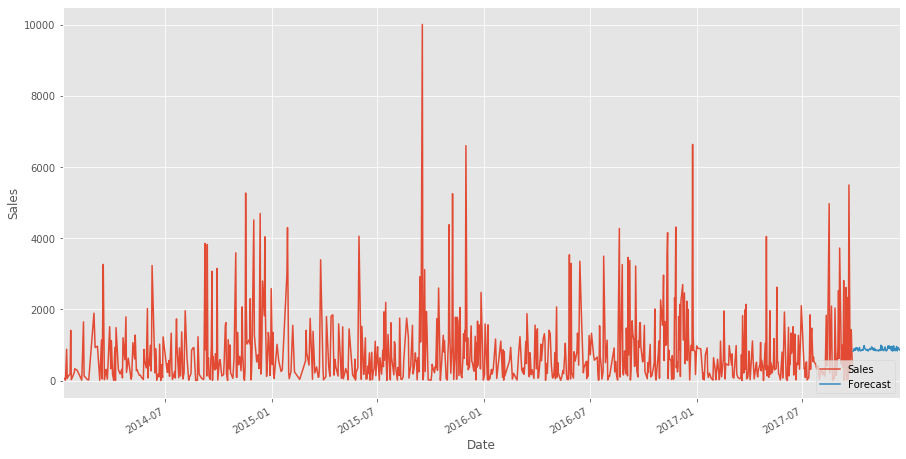

In [106]:
final_df['Sales'].plot(figsize=(15, 8))
final_df['Forecast'].plot(figsize=(15, 8))
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()